In [1]:
import torch

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
model = torch.load('new_model.pkl', map_location=torch.device('cpu'))

c:\Users\phamv\.conda\envs\chatbot\lib\site-packages\torch\serialization.py:453: SourceChangeWarning: source code of class 'models.module.ModelManager' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
c:\Users\phamv\.conda\envs\chatbot\lib\site-packages\torch\serialization.py:453: SourceChangeWarning: source code of class 'models.module.LSTMDecoder' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


In [4]:
import os, json, random
import numpy as np
import torch
from models.module import ModelManager
from utils.loader import DatasetManager
from utils.process import Processor
from utils.config import *
# Save training and model parameters.
if not os.path.exists(args.save_dir):
    os.system("mkdir -p " + args.save_dir)

log_path = os.path.join(args.save_dir, "param.json")
with open('param.json', "w", encoding="utf8") as fw:
    fw.write(json.dumps(args.__dict__, indent=True))

# Fix the random seed of package random.
random.seed(args.random_state)
np.random.seed(args.random_state)

# Fix the random seed of Pytorch when using GPU.
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(args.random_state)
    torch.cuda.manual_seed(args.random_state)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Fix the random seed of Pytorch when using CPU.
torch.manual_seed(args.random_state)
torch.random.manual_seed(args.random_state)

# Instantiate a dataset object.
dataset = DatasetManager(args)
dataset.quick_build()
dataset.show_summary()


{'data_dir': './data/MixSNIPS', 'save_dir': './save/MixSNIPS', 'load_dir': None, 'log_dir': './log/MixSNIPS', 'log_name': 'log.txt', 'random_state': 72, 'gpu': False, 'num_epoch': 50, 'batch_size': 64, 'l2_penalty': 1e-06, 'learning_rate': 0.001, 'dropout_rate': 0.4, 'gat_dropout_rate': 0.4, 'slot_forcing_rate': 0.9, 'threshold': 0.5, 'row_normalized': True, 'early_stop': False, 'patience': 10, 'n_heads': 8, 'alpha': 0.2, 'decoder_gat_hidden_dim': 16, 'n_layers_decoder': 2, 'word_embedding_dim': 32, 'intent_embedding_dim': 64, 'slot_embedding_dim': 32, 'encoder_hidden_dim': 256, 'slot_decoder_hidden_dim': 64, 'attention_hidden_dim': 1024, 'attention_output_dim': 128}
Training parameters are listed as follows:

	number of train sample:                    45000;
	number of dev sample:                      2500;
	number of test sample:                     2500;
	number of epoch:						    50;
	batch size:							    64;
	learning rate:							    0.001;
	random seed:							    72;
	rate of l

In [ ]:
dataloader = dataset.batch_delivery('train')

In [ ]:
text_batch, slot_batch, intent_batch = next(iter(dataloader))

In [ ]:
padded_text, [sorted_slot, sorted_intent], seq_lens = dataset.add_padding(text_batch, [(slot_batch, True), (intent_batch, False)])

In [ ]:
def multilabel2one_hot(labels, nums):
    res = [0.] * nums
    if len(labels) == 0:
        return res
    if isinstance(labels[0], list):
        for label in labels[0]:
            res[label] = 1.
        return res
    for label in labels:
        res[label] = 1.
    return res


def instance2onehot(func, num_intent, data):
    res = []
    for intents in func(data):
        res.append(multilabel2one_hot(intents, num_intent))
    return np.array(res)


In [ ]:
sorted_intent = [multilabel2one_hot(intents, len(dataset.intent_alphabet)) for intents in
                                 sorted_intent]
text_var = torch.LongTensor(padded_text)
slot_var = torch.LongTensor(sorted_slot)
intent_var = torch.Tensor(sorted_intent)

In [23]:
model_new = ModelManager(
    args, len(dataset.word_alphabet),
    len(dataset.slot_alphabet),
    len(dataset.intent_alphabet)
)
model_new.show_summary()

Model parameters are listed as follows:

	number of word:                            11411;
	number of slot:                            72;
	number of intent:						    7;
	word embedding dimension:				    32;
	encoder hidden dimension:				    256;
	dimension of intent embedding:		    	64;
	dimension of slot embedding:			    32;
	dimension of slot decoder hidden:  	    64;
	hidden dimension of self-attention:        1024;
	output dimension of self-attention:        128;
Changed!

End of parameters show. Now training begins.




c:\Users\phamv\.conda\envs\chatbot\lib\site-packages\torch\nn\modules\rnn.py:51: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.4 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [24]:
model_new.load_state_dict(model.state_dict())

<All keys matched successfully>

In [18]:
torch.save(model_new, "new_model.pkl")

In [ ]:
slot_out, intent_out = model(text_var, seq_lens, forced_slot=slot_var)

In [ ]:
ss, pred_slot, real_slot, pred_intent, real_intent = Processor.prediction(
            model_new, dataset, "test", args.batch_size, args)

In [48]:
texts = ["can you add confessions to my playlist called clasica and what is the weather forecast for close-by burkina"]

In [49]:
from nltk.tokenize import word_tokenize

In [575]:
def tokenize_texts(texts):
    tokenized_texts = []
    for text in texts:
        print(word_tokenize(text))
        tokenized_texts.append(word_tokenize(text))
    
    return tokenized_texts

In [51]:
tokenized_texts = tokenize_texts(texts)

['can', 'you', 'add', 'confessions', 'to', 'my', 'playlist', 'called', 'clasica', 'and', 'what', 'is', 'the', 'weather', 'forecast', 'for', 'close-by', 'burkina']


In [555]:
import matplotlib.pyplot as plt

def visualize_slot_intent_cor(mat, intent_indexs, name, show_pred=False):
    dim_nums = list(mat.shape)

    assert len(dim_nums)==3

    intent_indexs = [idx+1 for idx in intent_indexs]

    sliced_mat = mat[:, 0, [intent_indexs]].squeeze(axis=1).transpose(1, 0)
    plt.figure(figsize=(10, 7))
    if name:
        plt.title(name, fontweight ="bold")
    plt.imshow(sliced_mat, cmap='Blues')

    if show_pred:
        vector = sliced_mat.max(axis=0)
        sliced_mat = sliced_mat == vector
        plt.figure(figsize=(10, 7))
        plt.title("pred " + name, fontweight ="bold")
        plt.imshow(sliced_mat , cmap='Blues')
    

['can', 'you', 'add', 'confessions', 'to', 'my', 'playlist', 'called', 'clasica', 'and', 'what', 'is', 'the', 'weather', 'forecast', 'for', 'close-by', 'burkina']


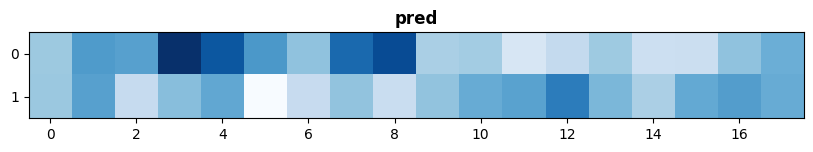

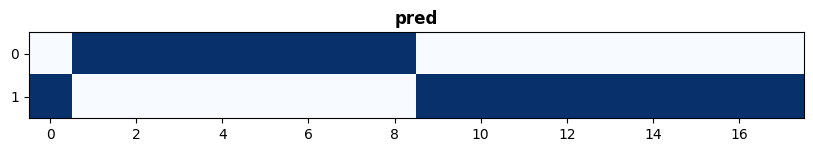

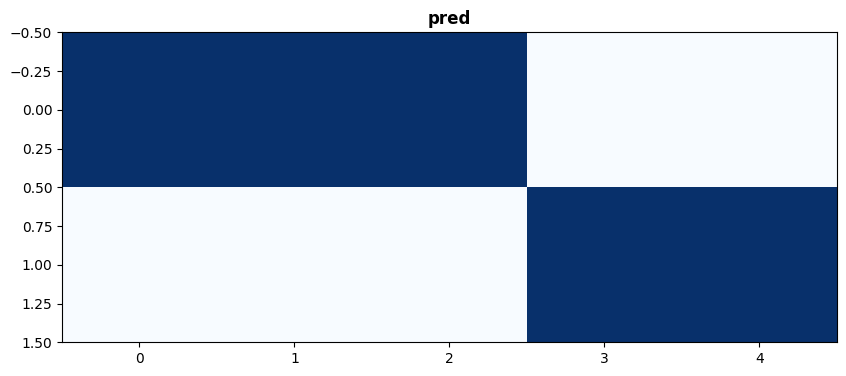

In [602]:
from utils.process import Evaluator
from models.module import ModelManager
import matplotlib.pyplot as plt

texts = ["can you add confessions to my playlist called clasica and what is the weather forecast for close-by burkina"]

tokenized_texts = tokenize_texts(texts)

model_new = ModelManager(
    args, len(dataset.word_alphabet),
    len(dataset.slot_alphabet),
    len(dataset.intent_alphabet)
)
model_new.load_state_dict(model.state_dict())

def prediction_deployment(model, batch_texts, dataset):
    pred_slot = []
    pred_intent = []

    padded_text, seq_lens = dataset.add_padding(
            batch_texts,
            digital=False
    )
    digit_text = dataset.word_alphabet.get_index(padded_text)
    var_text = torch.LongTensor(digit_text)
    slot_idx, intent_idx, matrix = model(var_text, seq_lens, n_predicts=1)
   
    nested_slot = Evaluator.nested_list([list(Evaluator.expand_list(slot_idx))], seq_lens)[0]
    pred_slot.extend(dataset.slot_alphabet.get_instance(nested_slot))
    intent_idx_ = [[] for _ in range(len(digit_text))]
    for item in intent_idx:
        intent_idx_[item[0]].append(item[1])
    intent_idx = intent_idx_
    pred_intent.extend(dataset.intent_alphabet.get_instance(intent_idx))

    matrix = matrix.cpu().data.numpy()
    matrix = matrix.squeeze(2)
    plt.figure(figsize=(10, 7))
    plt.title("pred", fontweight ="bold")
    final_matrix = np.transpose(matrix, (1, 0))[intent_idx[0]]
    plt.imshow(final_matrix, cmap='Blues')

    vector = final_matrix.max(axis=0)
    final_matrix = final_matrix == vector
    plt.figure(figsize=(10, 7))
    plt.title("pred", fontweight ="bold")
    plt.imshow(final_matrix , cmap='Blues')

    plt.figure(figsize=(10, 7))
    plt.title("pred", fontweight ="bold")
    plt.imshow(final_matrix[:, [3, 5, 8, 16, 17]] , cmap='Blues')

    # stack_mats = []
    # for i in range(9):
    #     att_matrix = matrix[:, i]
    #     att_matrix = att_matrix.reshape(seq_lens[0], 8, 8)
    #     stack_mats.append(att_matrix)
    #     if i==8:
    #         visualize_slot_intent_cor(att_matrix, intent_idx[0], "Mat Out"+str(i+1), show_pred=True)
    #     else:
    #         visualize_slot_intent_cor(att_matrix, intent_idx[0], "Mat"+str(i+1), show_pred=True)

    # sum_mat = np.stack(stack_mats).sum(axis=0)
    # visualize_slot_intent_cor(sum_mat, intent_idx[0], "Sum Mat With Out"+str(10.1))

    # sum_mat = np.stack(stack_mats[:-1]).sum(axis=0)
    # visualize_slot_intent_cor(sum_mat, intent_idx[0], "Sum Mat Without Out"+str(10.2))

    # avg_mat = np.stack(stack_mats).mean(axis=0)
    # visualize_slot_intent_cor(avg_mat, intent_idx[0], "Mean Mat With Out"+str(11.1))

    # avg_mat = np.stack(stack_mats[:-1]).mean(axis=0)
    # visualize_slot_intent_cor(avg_mat, intent_idx[0], "Mean Mat Without Out"+str(11.1))

    # word_mat = np.expand_dims(matrix[:, 0], 1)
    # matrix = word_mat@matrix.transpose(0, 2, 1)
    # matrix = matrix.squeeze(1)
    # matrix = matrix.transpose(1, 0)
    # final_matrix = matrix[[idx+1 for idx in intent_idx[0]]]
    # plt.figure(figsize=(10, 7))
    # plt.title("cosine similarity", fontweight ="bold")
    # plt.imshow(final_matrix , cmap='Blues')

    
    return pred_intent, pred_slot

pred_intent, pred_slot = prediction_deployment(model_new, tokenized_texts, dataset)
# pred_intent, pred_slot

In [587]:
pred_intent, pred_slot

([['AddToPlaylist', 'GetWeather']],
 [['O',
   'O',
   'O',
   'B-entity_name',
   'O',
   'B-playlist_owner',
   'O',
   'O',
   'B-playlist',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B-geographic_poi',
   'B-country']])

In [609]:
a = np.array([[True,False,True,True],
              [False,True,False,False]])
print(a.dtype)
np.where(a==1)

bool


(array([0, 0, 0, 1], dtype=int64), array([0, 2, 3, 1], dtype=int64))

In [ ]:
0,2 1,1